# Compute Vision Assignment 1

## Group Details 
Group 43


| Name             | Roll No      | Contribution    |
|------------      |-----         |------------     |
| Archan Ghosh     |  2023AC05402 | 100             |
| Jawaharlal Rajan S       |  2023AC05504            |      100           |
|          Saransh Gupta        |  2023AC05284            |  100               |
|         Saurabh Gupta         |  2023AC05582            |          100       |
|        SHAILESH KUMAR SINGH          |     2023AC05475         |       100          |

# Problem Statement

**To classify satellite images from the EuroSAT dataset into various land-use
categories (e.g., forest, river, industrial, residential) by extracting low-level and
mid-level vision features and training a classical machine learning model**

# Unzipping the dataset

In [125]:
import os
import urllib.request
import zipfile

DATASET_PATH = 'EuroSAT_RGB'

if os.path.exists(DATASET_PATH):
    print("EuroSAT_RGB dataset already exists.")
else:
    print("Downloading EuroSAT_RGB dataset...")
    # Download the EuroSAT_RGB dataset
    url = "https://zenodo.org/record/7711810/files/EuroSAT_RGB.zip?download=1"
    urllib.request.urlretrieve(url, "EuroSAT_RGB.zip")
    with zipfile.ZipFile("EuroSAT_RGB.zip", 'r') as zip_ref:
        zip_ref.extractall()
    print("EuroSAT_RGB dataset downloaded and extracted.")

EuroSAT_RGB dataset already exists.


# Importing Required Libraries

In [126]:
import os
import numpy as np
import cv2

from skimage.feature import local_binary_pattern
from skimage.color import rgb2gray

import matplotlib.pyplot as plt
import random

from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, average_precision_score, classification_report
)
from sklearn.preprocessing import label_binarize

# change this to run on different samples
SEED = 42
random.seed(SEED)


# Data loading Pipeline

In [127]:
SELECTED_CLASSES = ['River', 'Forest', 'Residential', 'Industrial', 'Highway']
IMG_SIZE = (64, 64)

def load_images(dataset_path, selected_classes, img_size):
    X, y = [], []
    label_map = {cls: idx for idx, cls in enumerate(selected_classes)}

    for cls in selected_classes:
        folder = os.path.join(dataset_path, cls)
        if not os.path.isdir(folder):
            print(f"[Warning] Folder {folder} not found.")
            continue

        for img_name in os.listdir(folder):
            img_path = os.path.join(folder, img_name)
            img = cv2.imread(img_path)
            if img is not None:
                img = cv2.resize(img, img_size)
                X.append(img)
                y.append(label_map[cls])

    X = np.array(X)
    y = np.array(y)
    return X, y, label_map

In [128]:
X, y, label_map = load_images(DATASET_PATH, SELECTED_CLASSES, IMG_SIZE)

print(f"Loaded {len(X)} images across {len(SELECTED_CLASSES)} classes.")
print(f"Label mapping: {label_map}")

Loaded 13500 images across 5 classes.
Label mapping: {'River': 0, 'Forest': 1, 'Residential': 2, 'Industrial': 3, 'Highway': 4}


# Feature Extraction Pipeline

In [129]:
def extract_features(image):
    features = []

    # 1. Grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # 2. Histogram Equalization
    equalized = cv2.equalizeHist(gray)
    hist_eq = cv2.calcHist([equalized], [0], None, [32], [0, 256])
    hist_eq = cv2.normalize(hist_eq, hist_eq).flatten()
    features.extend(hist_eq)

    # 3. Gaussian Blur
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    hist_blur = cv2.calcHist([blurred], [0], None, [32], [0, 256])
    hist_blur = cv2.normalize(hist_blur, hist_blur).flatten()
    features.extend(hist_blur)

    # 4. Canny Edge Detection (mean edge intensity)
    edges = cv2.Canny(gray, 100, 200)
    features.append(np.mean(edges) / 255.0)

    # 5. Local Binary Pattern (LBP)
    lbp = local_binary_pattern(gray, P=8, R=1, method='uniform')
    (lbp_hist, _) = np.histogram(lbp.ravel(), bins=np.arange(0, 59))
    lbp_hist = lbp_hist.astype("float")
    lbp_hist /= (lbp_hist.sum() + 1e-6)
    features.extend(lbp_hist)

    return np.array(features)

In [130]:
X_features = np.array([extract_features(img) for img in X])
print(f"Feature extraction complete. Feature shape: {X_features.shape}")

Feature extraction complete. Feature shape: (13500, 123)


## Showcasing Few Samples

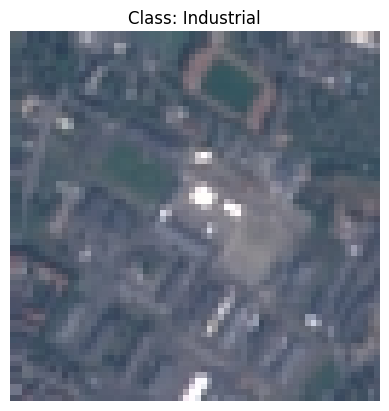

Feature vector length: 123
First 10 features: [0.14542277 0.1626091  0.15732101 0.19433771 0.09915189 0.22210023
 0.10443999 0.13352455 0.29348961 0.12294834]
Mean: 0.0726, Std: 0.1096
--------------------------------------------------


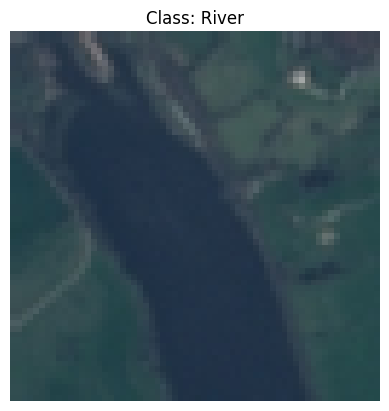

Feature vector length: 123
First 10 features: [0.15461643 0.         0.25257951 0.         0.         0.37532845
 0.         0.32811731 0.1841234  0.21953173]
Mean: 0.0650, Std: 0.1138
--------------------------------------------------


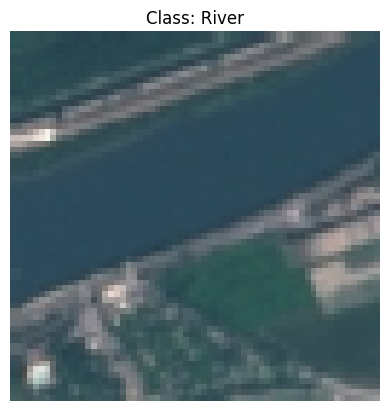

Feature vector length: 123
First 10 features: [0.09559107 0.12019867 0.0861266  0.         0.         0.34166709
 0.         0.         0.         0.        ]
Mean: 0.0582, Std: 0.1181
--------------------------------------------------


In [131]:
sample_indices = random.sample(range(len(X)), 3)

for idx in sample_indices:
    img = X[idx]
    feats = X_features[idx]

    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title(f"Class: {list(label_map.keys())[y[idx]]}")
    plt.axis('off')
    plt.show()

    print(f"Feature vector length: {len(feats)}")
    print(f"First 10 features: {feats[:10]}")
    print(f"Mean: {np.mean(feats):.4f}, Std: {np.std(feats):.4f}")
    print("-" * 50)

# Model Training

## Test Train Split

In [132]:
indices = np.arange(len(X))
X_train, X_test, y_train, y_test, train_idx, test_idx = train_test_split(X_features, y, indices, test_size=0.2, stratify=y, random_state=SEED)

## Cross Validation

In [133]:
rf_model = RandomForestClassifier(n_estimators=100, random_state=SEED)

rf_scores = cross_val_score(rf_model, X_train, y_train, cv=5)

print(f"Cross-validation accuracy: {rf_scores.mean():.4f} ± {rf_scores.std():.4f}")

Cross-validation accuracy: 0.8930 ± 0.0056


In [134]:
svm_model = SVC(kernel='rbf', gamma='scale', probability=True, random_state=SEED)

svm_scores = cross_val_score(svm_model, X_train, y_train, cv=5)

print(f"SVM Cross-validation accuracy: {svm_scores.mean():.4f} ± {svm_scores.std():.4f}")

SVM Cross-validation accuracy: 0.8605 ± 0.0054


In [135]:
xgb_model = XGBClassifier(eval_metric='mlogloss', random_state=SEED)

xgb_scores = cross_val_score(xgb_model, X_train, y_train, cv=5)

print(f"XGBoost Cross-validation accuracy: {xgb_scores.mean():.4f} ± {xgb_scores.std():.4f}")

XGBoost Cross-validation accuracy: 0.9047 ± 0.0047


## Cross Validation Comparison

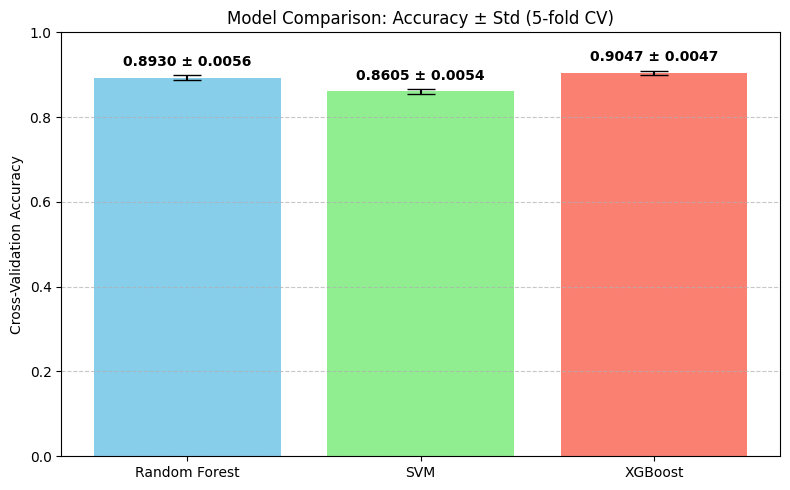

In [136]:
models = ['Random Forest', 'SVM', 'XGBoost']
means = [rf_scores.mean(), svm_scores.mean(), xgb_scores.mean()]
stds = [rf_scores.std(), svm_scores.std(), xgb_scores.std()]


plt.figure(figsize=(8, 5))
bars = plt.bar(models, means, yerr=stds, capsize=10, color=['skyblue', 'lightgreen', 'salmon'])

plt.ylabel('Cross-Validation Accuracy')
plt.title('Model Comparison: Accuracy ± Std (5-fold CV)')
plt.ylim(0, 1.0)
plt.grid(axis='y', linestyle='--', alpha=0.7)

for bar, mean, std in zip(bars, means, stds):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, height + 0.02,
             f'{mean:.4f} ± {std:.4f}',
             ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

## Training on Full dataset

As we saw that the scores from cross validation are very similar we will proceed to train the models, and do a comparison on F1 Score and mAP to determine the best model.

### Random Forest

In [137]:
rf_model.fit(X_train, y_train)

y_pred = rf_model.predict(X_test)

rf_acc = accuracy_score(y_test, y_pred)
rf_prec = precision_score(y_test, y_pred, average='weighted')
rf_rec = recall_score(y_test, y_pred, average='weighted')
rf_f1 = f1_score(y_test, y_pred, average='weighted')

print("Evaluation Metrics For Random Forest:")
print(f"Accuracy       : {rf_acc:.4f}")
print(f"Precision      : {rf_prec:.4f}")
print(f"Recall         : {rf_rec:.4f}")
print(f"F1-Score       : {rf_f1:.4f}")

Evaluation Metrics For Random Forest:
Accuracy       : 0.8907
Precision      : 0.8889
Recall         : 0.8907
F1-Score       : 0.8894


In [138]:
print("\nClassification Report for Random Forest:")
print(classification_report(y_test, y_pred, target_names=list(label_map.keys())))


Classification Report for Random Forest:
              precision    recall  f1-score   support

       River       0.83      0.83      0.83       500
      Forest       0.99      0.98      0.99       600
 Residential       0.95      0.97      0.96       600
  Industrial       0.87      0.92      0.89       500
     Highway       0.77      0.71      0.74       500

    accuracy                           0.89      2700
   macro avg       0.88      0.88      0.88      2700
weighted avg       0.89      0.89      0.89      2700



In [139]:
y_test_bin = label_binarize(y_test, classes=np.arange(len(label_map)))
y_score_prob = rf_model.predict_proba(X_test)

rf_mAP = average_precision_score(y_test_bin, y_score_prob, average='macro')
print(f"\nMean Average Precision (mAP) for Random Forest: {rf_mAP:.4f}")


Mean Average Precision (mAP) for Random Forest: 0.9364


### SVM

In [140]:
svm_model.fit(X_train, y_train)

y_pred = svm_model.predict(X_test)

svm_acc = accuracy_score(y_test, y_pred)
svm_prec = precision_score(y_test, y_pred, average='weighted')
svm_rec = recall_score(y_test, y_pred, average='weighted')
svm_f1 = f1_score(y_test, y_pred, average='weighted')

print("Evaluation Metrics For SVM Classifier:")
print(f"Accuracy       : {svm_acc:.4f}")
print(f"Precision      : {svm_prec:.4f}")
print(f"Recall         : {svm_rec:.4f}")
print(f"F1-Score       : {svm_f1:.4f}")

Evaluation Metrics For SVM Classifier:
Accuracy       : 0.8607
Precision      : 0.8580
Recall         : 0.8607
F1-Score       : 0.8585


In [141]:
print("\nClassification Report for SVM Classifier:")
print(classification_report(y_test, y_pred, target_names=list(label_map.keys())))


Classification Report for SVM Classifier:
              precision    recall  f1-score   support

       River       0.83      0.73      0.78       500
      Forest       0.96      0.98      0.97       600
 Residential       0.91      0.97      0.94       600
  Industrial       0.86      0.90      0.88       500
     Highway       0.70      0.68      0.69       500

    accuracy                           0.86      2700
   macro avg       0.85      0.85      0.85      2700
weighted avg       0.86      0.86      0.86      2700



In [142]:
y_test_bin = label_binarize(y_test, classes=np.arange(len(label_map)))
y_score_prob = svm_model.predict_proba(X_test)

svm_mAP = average_precision_score(y_test_bin, y_score_prob, average='macro')
print(f"\nMean Average Precision (mAP) for SVM Classifier: {svm_mAP:.4f}")


Mean Average Precision (mAP) for SVM Classifier: 0.9114


### XGBoost Classifier

In [143]:
xgb_model.fit(X_train, y_train)

y_pred = xgb_model.predict(X_test)

xgb_acc = accuracy_score(y_test, y_pred)
xgb_prec = precision_score(y_test, y_pred, average='weighted')
xgb_rec = recall_score(y_test, y_pred, average='weighted')
xgb_f1 = f1_score(y_test, y_pred, average='weighted')

print("Evaluation Metrics For XGBoost Classifier:")
print(f"Accuracy       : {xgb_acc:.4f}")
print(f"Precision      : {xgb_prec:.4f}")
print(f"Recall         : {xgb_rec:.4f}")
print(f"F1-Score       : {xgb_f1:.4f}")

Evaluation Metrics For XGBoost Classifier:
Accuracy       : 0.9004
Precision      : 0.8999
Recall         : 0.9004
F1-Score       : 0.9000


In [144]:
print("\nClassification Report for XGBoost Classifier:")
print(classification_report(y_test, y_pred, target_names=list(label_map.keys())))


Classification Report for XGBoost Classifier:
              precision    recall  f1-score   support

       River       0.86      0.82      0.84       500
      Forest       0.99      0.99      0.99       600
 Residential       0.96      0.97      0.97       600
  Industrial       0.89      0.92      0.90       500
     Highway       0.77      0.77      0.77       500

    accuracy                           0.90      2700
   macro avg       0.89      0.89      0.89      2700
weighted avg       0.90      0.90      0.90      2700



In [145]:
y_test_bin = label_binarize(y_test, classes=np.arange(len(label_map)))
y_score_prob = xgb_model.predict_proba(X_test)

xgb_mAP = average_precision_score(y_test_bin, y_score_prob, average='macro')
print(f"\nMean Average Precision (mAP) for XGBoost Classifier: {xgb_mAP:.4f}")


Mean Average Precision (mAP) for XGBoost Classifier: 0.9470


# Analysis of 3 Models

## Comparison of F1-score, Accuracy, Precision and Recall

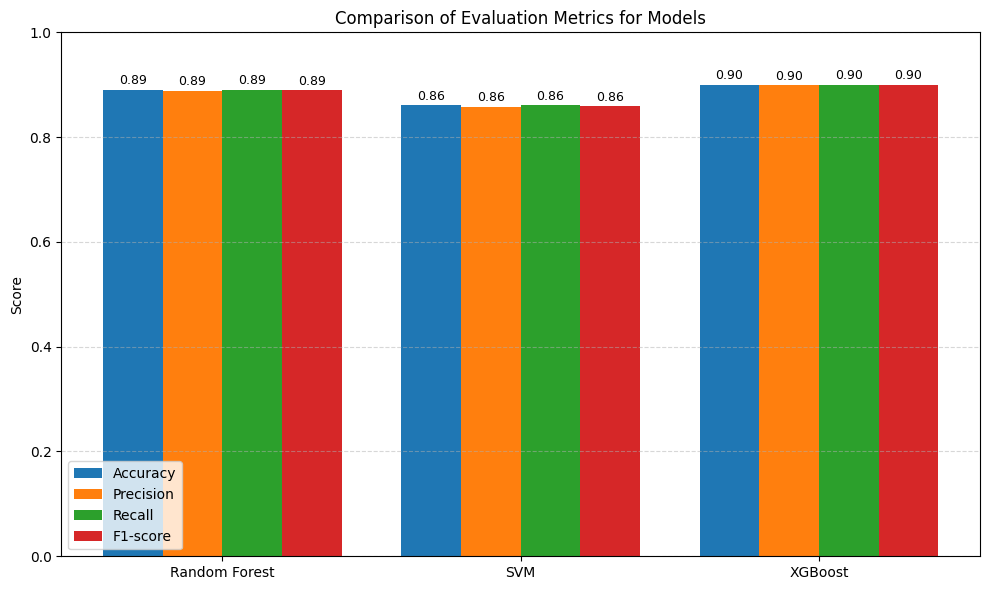

In [146]:
accuracy = [rf_acc, svm_acc, xgb_acc]
precision = [rf_prec, svm_prec, xgb_prec]
recall = [rf_rec, svm_rec, xgb_rec]
f1 = [rf_f1, svm_f1, xgb_f1]


metrics = ['Accuracy', 'Precision', 'Recall', 'F1-score']
models = ['Random Forest', 'SVM', 'XGBoost']
metric_values = [accuracy, precision, recall, f1]

x = np.arange(len(models))
width = 0.2


plt.figure(figsize=(10, 6))

for i, metric in enumerate(metric_values):
    plt.bar(x + i*width - width*1.5, metric, width, label=metrics[i])


plt.ylabel('Score')
plt.title('Comparison of Evaluation Metrics for Models')
plt.xticks(x, models)
plt.ylim(0, 1.0)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.5)


for i, metric in enumerate(metric_values):
    for j, val in enumerate(metric):
        plt.text(j + i*width - width*1.5, val + 0.01, f'{val:.2f}', ha='center', fontsize=9)

plt.tight_layout()
plt.show()

## Comparison of mAP

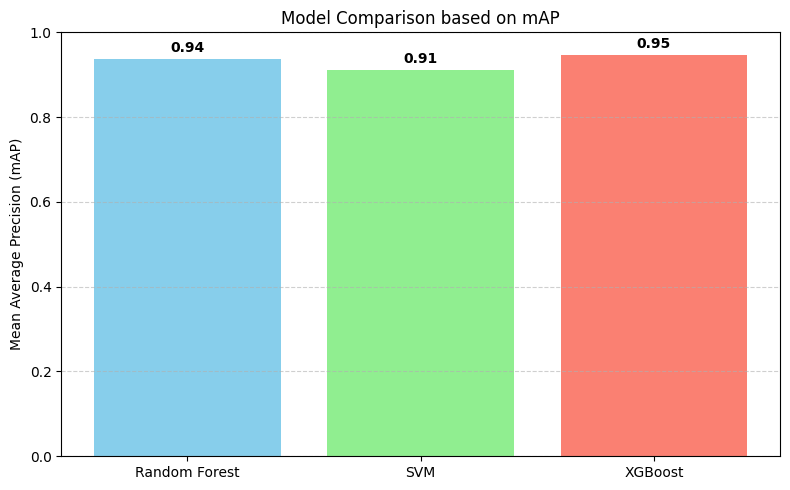

In [147]:
models = ['Random Forest', 'SVM', 'XGBoost']
mAP_scores = [rf_mAP, svm_mAP, xgb_mAP]


plt.figure(figsize=(8, 5))
bars = plt.bar(models, mAP_scores, color=['skyblue', 'lightgreen', 'salmon'])


plt.ylabel('Mean Average Precision (mAP)')
plt.title('Model Comparison based on mAP')
plt.ylim(0, 1.0)
plt.grid(axis='y', linestyle='--', alpha=0.6)


for bar, score in zip(bars, mAP_scores):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2.0, height + 0.01,
             f'{score:.2f}', ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

# Understanding

**We can see that the XGBoost Model is performing the best among the 3, now to get deeper into the problem, lets experiment with feature engineering and see how the results vary**



# Feature Engineering Combinations with XGBoost

## Feature Combination

In [148]:
def extract_features(image, use_hist_eq=True, use_blur=True, use_canny=True, use_lbp=True):
    features = []
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    if use_hist_eq:
        equalized = cv2.equalizeHist(gray)
        hist_eq = cv2.calcHist([equalized], [0], None, [32], [0, 256])
        hist_eq = cv2.normalize(hist_eq, hist_eq).flatten()
        features.extend(hist_eq)

    if use_blur:
        blurred = cv2.GaussianBlur(gray, (5, 5), 0)
        hist_blur = cv2.calcHist([blurred], [0], None, [32], [0, 256])
        hist_blur = cv2.normalize(hist_blur, hist_blur).flatten()
        features.extend(hist_blur)

    if use_canny:
        edges = cv2.Canny(gray, 100, 200)
        features.append(np.mean(edges) / 255.0)

    if use_lbp:
        lbp = local_binary_pattern(gray, P=8, R=1, method='uniform')
        (lbp_hist, _) = np.histogram(lbp.ravel(), bins=np.arange(0, 59))
        lbp_hist = lbp_hist.astype("float")
        lbp_hist /= (lbp_hist.sum() + 1e-6)
        features.extend(lbp_hist)

    return np.array(features)

In [149]:
feature_configs = {
    "HistEq": (True, False, False, False),
    "Blur": (False, True, False, False),
    "Canny": (False, False, True, False),
    "LBP": (False, False, False, True),
    "HistEq+LBP": (True, False, False, True),
    "Canny+LBP": (False, False, True, True),
    "HistEq+Blur+LBP": (True, True, False, True),
    "All": (True, True, True, True),
}

In [150]:
def extract_features_dataset(images, config_flags):
    return np.array([extract_features(img, *config_flags) for img in images])

## Feature wise Training

In [151]:
results = {}

for config_name, flags in feature_configs.items():
    print(f"\nProcessing: {config_name}")

    X_feat = extract_features_dataset(X, flags)

    X_train, X_test, y_train, y_test = train_test_split(
        X_feat, y, test_size=0.2, stratify=y, random_state=SEED
    )

    model = XGBClassifier(eval_metric='mlogloss', random_state=SEED)
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    y_score = model.predict_proba(X_test)

    y_test_bin = label_binarize(y_test, classes=np.unique(y))

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, average='weighted', zero_division=0)
    rec = recall_score(y_test, y_pred, average='weighted', zero_division=0)
    f1 = f1_score(y_test, y_pred, average='weighted')
    mAP = average_precision_score(y_test_bin, y_score, average='macro')

    results[config_name] = {
        "accuracy": acc,
        "precision": prec,
        "recall": rec,
        "f1_score": f1,
        "mAP": mAP,
        "model": model,
        "X_test": X_test,
    }


Processing: HistEq

Processing: Blur

Processing: Canny

Processing: LBP

Processing: HistEq+LBP

Processing: Canny+LBP

Processing: HistEq+Blur+LBP

Processing: All


## Results

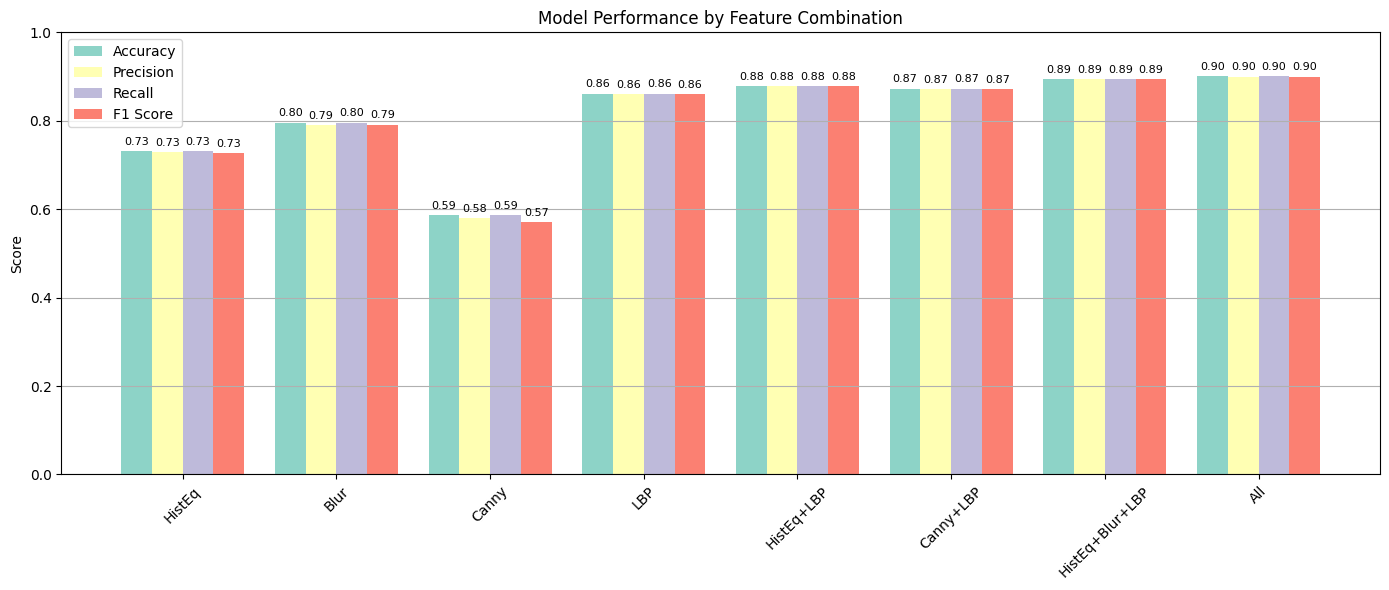

In [152]:
def add_labels(bars):
    for bar in bars:
        height = bar.get_height()
        plt.annotate(f'{height:.2f}',
                     xy=(bar.get_x() + bar.get_width() / 2, height),
                     xytext=(0, 3),
                     textcoords="offset points",
                     ha='center', va='bottom',
                     fontsize=8)

configs = list(results.keys())
accs = [results[c]["accuracy"] for c in configs]
f1s = [results[c]["f1_score"] for c in configs]
precs = [results[c]["precision"] for c in configs]
recs = [results[c]["recall"] for c in configs]

x = np.arange(len(configs))
width = 0.2

colors = plt.get_cmap('Set3').colors

plt.figure(figsize=(14, 6))

bars_acc = plt.bar(x - 1.5*width, accs, width, label='Accuracy', color=colors[0])
bars_prec = plt.bar(x - 0.5*width, precs, width, label='Precision', color=colors[1])
bars_rec = plt.bar(x + 0.5*width, recs, width, label='Recall', color=colors[2])
bars_f1 = plt.bar(x + 1.5*width, f1s, width, label='F1 Score', color=colors[3])

plt.ylabel('Score')
plt.title('Model Performance by Feature Combination')
plt.xticks(x, configs, rotation=45)
plt.ylim(0, 1)
plt.legend()
plt.tight_layout()
plt.grid(axis='y')

add_labels(bars_acc)
add_labels(bars_prec)
add_labels(bars_rec)
add_labels(bars_f1)

plt.show()

### Mean Average Precision

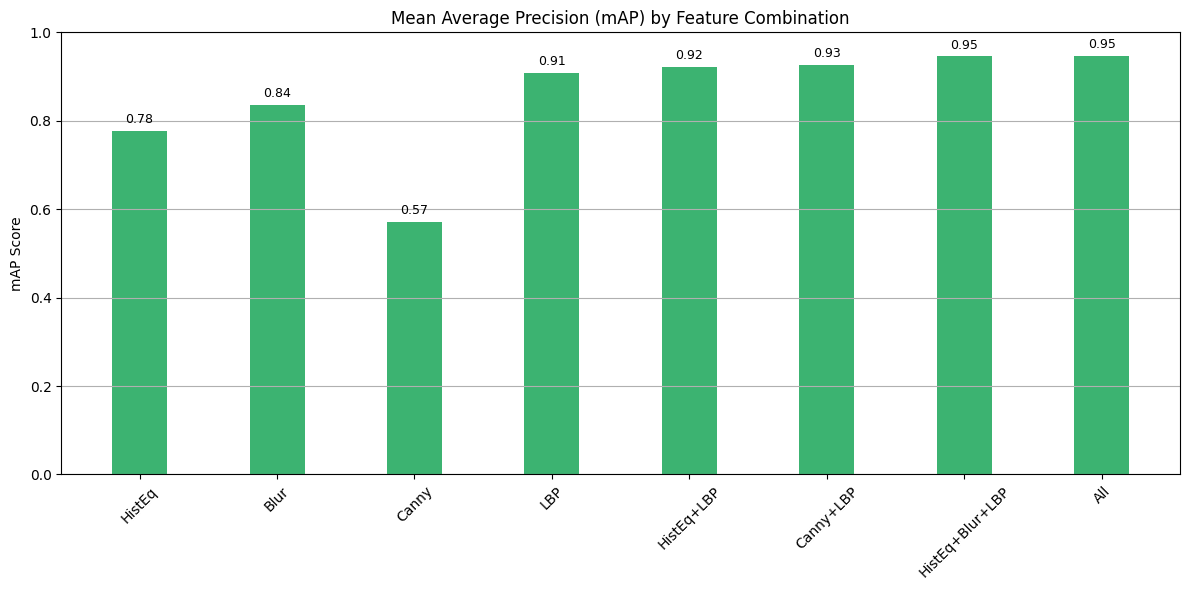

In [153]:
configs = list(results.keys())
maps = [results[c]["mAP"] for c in configs]

x = np.arange(len(configs))
width = 0.4

plt.figure(figsize=(12, 6))
bars = plt.bar(x, maps, width, color='mediumseagreen', label='mAP')

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, height + 0.01, f'{height:.2f}', ha='center', va='bottom', fontsize=9)

plt.ylabel('mAP Score')
plt.title('Mean Average Precision (mAP) by Feature Combination')
plt.xticks(x, configs, rotation=45)
plt.ylim(0, 1)
plt.tight_layout()
plt.grid(axis='y')
plt.show()

# Inference

HistEq+Blur+LBP combination is best performing with mAP of 0.95. Let's try some inference using the best performing model + feature engineering combinations. i.e All filters that has 0.9 accuracy

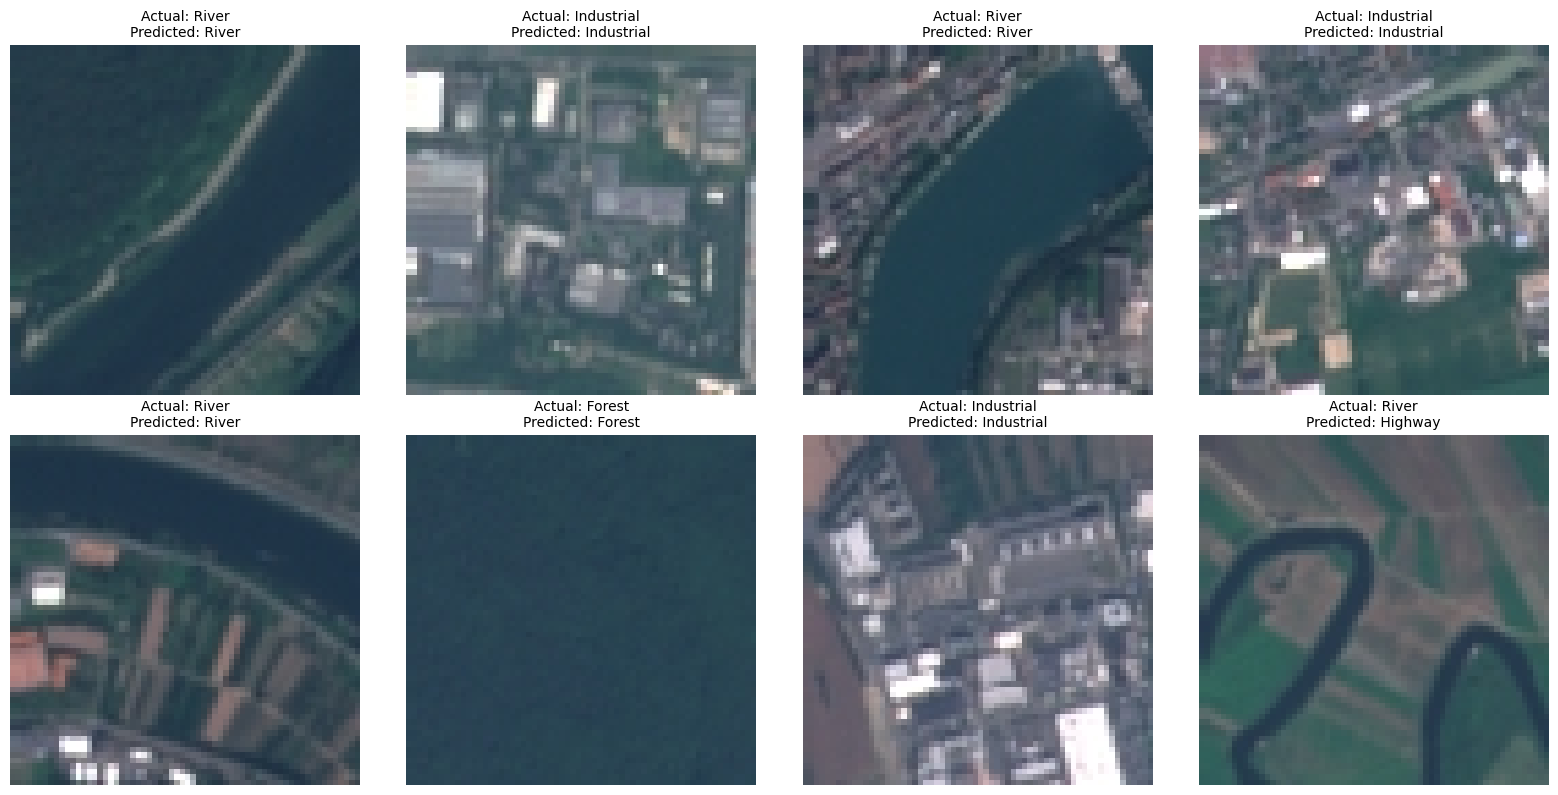

In [156]:
inv_label_map = {v: k for k, v in label_map.items()}

best_model_feature = results["All"]
X_test = best_model_feature["X_test"]
xgb_model = best_model_feature["model"]

sample_indices = random.sample(range(len(X_test)), 8)

# Visualizing predictions for the test set
fig, axes = plt.subplots(2, 4, figsize=(16, 8))
axes = axes.flatten()

for i, idx in enumerate(sample_indices):
    original_img = X[test_idx[idx]]

    # original_img = X[np.where((X_features == X_test[idx]).all(axis=1))[0][0]]

    true_label = inv_label_map[y_test[idx]]
    pred_label = inv_label_map[xgb_model.predict([X_test[idx]])[0]]

    ax = axes[i]
    ax.imshow(cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB))
    ax.set_title(f"Actual: {true_label}\nPredicted: {pred_label}", fontsize=10)
    ax.axis('off')

plt.tight_layout()
plt.show()

# Conclusion

### Analysis
#### Top Performance
The model achieves its best performance when using the HistogramEqualization+Blur+LBP and All feature combinations. For both of these, all four metrics reach a peak score of 0.91. Mean Average Precision is at peak. i.e 0.95. This suggests that adding the Canny feature to the HistEq+Blur+LBP combination does not improve much (0.89 to 0.9).

#### Most Influential Feature
LBP (Local Binary Patterns) is the most impactful feature. By itself, it yields high scores of 0.86. Every combination that includes LBP results in the highest scores across the board (0.86 to 0.91).

#### Least Effective Feature
The Canny edge detection feature, when used alone, results in the poorest performance, with scores dropping to between 0.58.

## Why (Justification for the above observation)

Canny is best to detect edges i.e. Lines where there are sharp changes in intensity. While satellite images do contain edges (e.g., river, forest, residential building outlines), relying only on them is problematic for this dataset. We need to capture texture, and LBP is a powerful texture descriptor.

This combination represents a perfect preprocessing and feature extraction pipeline for this problem:

* Histogram-Equalization: First, you enhance the contrast of the image to make features more distinct.
* Blur: Next, you suppress minor noise and irrelevant fine details.
* LBP: Finally, you apply the powerful LBP operator to the cleaned, high-contrast image to extract the core discriminative textures.